In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
raw_data      = pd.read_csv('../data/sentence-relations/train.csv', index_col='id')
raw_submissions = pd.read_csv('../data/sentence-relations/test.csv', index_col='id')

# Drop chinese and thai
# raw_data = raw_data[raw_data['lang_abv'] != 'zh']
# raw_data = raw_data[raw_data['lang_abv'] != 'th']

# Only take english
raw_data = raw_data[raw_data['lang_abv'] == 'en']

training_data, test_data = train_test_split(raw_data, test_size=0.2, random_state=42)

training_data.head()

,premise,hypothesis,lang_abv,language,label
id,,,,,
b6e01c1a07,"Also, the Holy Family are said to have shelter...",The Holy family spent a total of three days here.,en,English,1
b8fa1a0044,Participants generally viewed the new internal...,Those organizations affected by the Sarbanes-O...,en,English,0
c828f51ef6,With a little practice almost anyone can flip ...,Practicing lets you do anything you put your m...,en,English,1
b2c98d5a99,More reserved and remote but a better administ...,The uncle had no match in administration; cert...,en,English,2
9cd35fee05,The company later told us that it had disconti...,The company later told us that it had enhanced...,en,English,2


In [3]:
from transformers import AutoModelForSequenceClassification, BertTokenizer, RobertaTokenizer
from transformers import pipeline

MODEL_MAPPING = {
    'bert-finetuned': 'bert-checkpoint-374-finetuned',
    'bert-retrained': 'bert-checkpoint-2752',
    'roberta-finetuned': 'roberta-checkpoint-4816-finetuned',
    'roberta-retrained': 'roberta-checkpoint-21816-all',
}

CURRENT_MODEL = MODEL_MAPPING['bert-finetuned']

pipelines = {}

bert_tokenizer    = BertTokenizer.from_pretrained('bert-base-uncased')
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

if CURRENT_MODEL.startswith('bert'):
    model = AutoModelForSequenceClassification.from_pretrained(f'./best-checkpoints/{CURRENT_MODEL}')
    tokenizer = bert_tokenizer
else:
    model = AutoModelForSequenceClassification.from_pretrained(f'./best-checkpoints/{CURRENT_MODEL}')
    tokenizer = roberta_tokenizer

pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

/home/alex/Documents/Studium/2-Master/ki-lab-ss23/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/alex/Documents/Studium/2-Master/ki-lab-ss23/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
from torch.utils.data import Dataset

class BertSentenceDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

        self.X = self.data['premise'] + '[SEP]' + self.data['hypothesis']
        self.y = self.data['label']

        self.encoded = self.tokenizer(self.X.tolist(), padding=True, truncation=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encoded['input_ids'][idx],
            'attention_mask': self.encoded['attention_mask'][idx],
            'label': self.y.iloc[idx]
        }

test_dataset = BertSentenceDataset(test_data, tokenizer)

In [5]:
# Evaluate BERT model
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

from sklearn.metrics import classification_report

data_collator = DataCollatorWithPadding(tokenizer)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    return classification_report(labels, preds, output_dict=True)

def evaluate_model(model, dataset):
    trainer = Trainer(
        model=model,
        eval_dataset=dataset,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )
    # Get predictions
    predictions = trainer.predict(dataset)

    return predictions

In [6]:
test_predictions = evaluate_model(model, test_dataset)

100%|██████████| 172/172 [00:04<00:00, 37.86it/s]


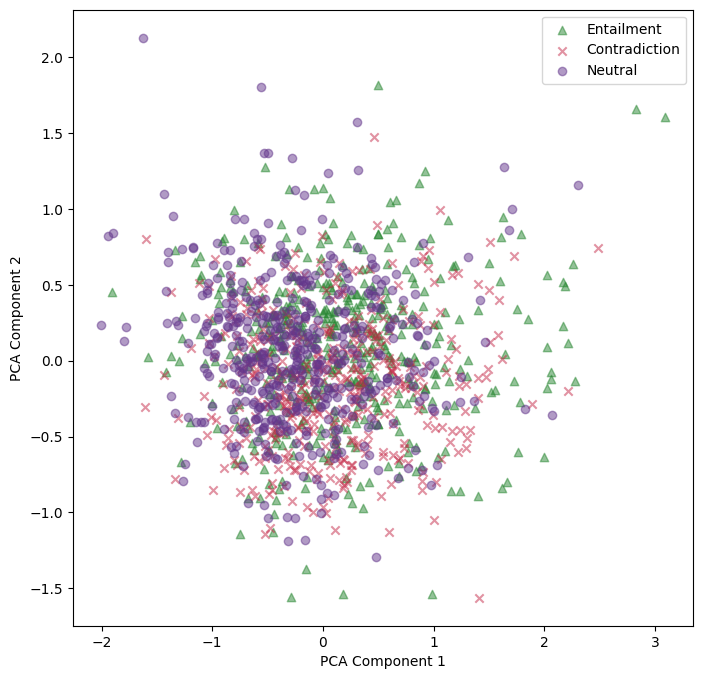

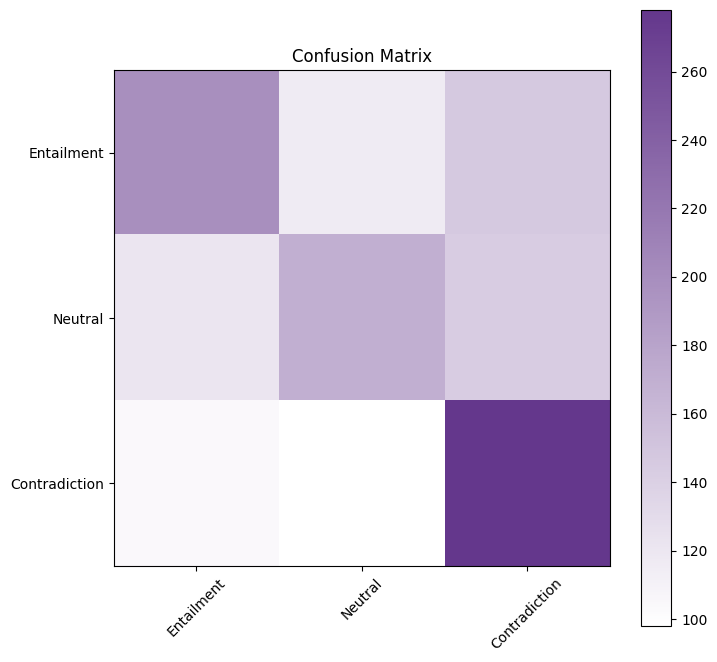

In [7]:
import numpy as np
import os

PLT_COLORS = ["#64378C", "#C42847", "#288732", "#E7F9A9", "#2DD881"]

def plot_results(test_predictions, test_dataset):
    predictions = test_predictions[0]
    ground_truth = test_predictions[1]
    test_results = test_predictions[2]

    # Perform PCA and plot the embeddings of the results
    from sklearn.decomposition import PCA

    pca = PCA(n_components=2)
    embeddings = predictions

    pca_embeddings = pca.fit_transform(embeddings)

    entilements    = []
    contradictions = []
    neutrals       = []

    for i, label in enumerate(ground_truth):
        if label == 0:
            entilements.append(pca_embeddings[i])
        elif label == 1:
            contradictions.append(pca_embeddings[i])
        else:
            neutrals.append(pca_embeddings[i])

    entilements    = np.array(entilements)
    contradictions = np.array(contradictions)
    neutrals       = np.array(neutrals)

    if not os.path.exists('./output'):
        os.makedirs('./output')

    if not os.path.exists(f'./output/{CURRENT_MODEL}'):
        os.makedirs(f'./output/{CURRENT_MODEL}')

    MODEL_PATH = f'./output/{CURRENT_MODEL}'

    plt.figure(figsize=(8, 8))
    plt.scatter(entilements[:, 0], entilements[:, 1], color=PLT_COLORS[2], label='Entailment', alpha=0.5, marker='^')
    plt.scatter(contradictions[:, 0], contradictions[:, 1], color=PLT_COLORS[1], label='Contradiction', alpha=0.5, marker='x')
    plt.scatter(neutrals[:, 0], neutrals[:, 1], color=PLT_COLORS[0], label='Neutral', alpha=0.5, marker='o')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.savefig(f'{MODEL_PATH}/pca-embeddings.pdf')
    plt.show()

    accuracy = test_results['test_accuracy']
    macro_test_results = test_results['test_macro avg']
    f1_score = macro_test_results['f1-score']
    runtime = test_results['test_runtime']

    with open(f'{MODEL_PATH}/results.txt', 'w') as f:
        f.write(f'Accuracy: {accuracy}\n')
        f.write(f'F1 Score: {f1_score}\n')
        f.write(f'Runtime: {runtime}\n')

    # Plot confusion matrix
    from sklearn.metrics import confusion_matrix
    from matplotlib.colors import LinearSegmentedColormap

    custom_cmap = LinearSegmentedColormap.from_list("custom", ["#FFFFFF", PLT_COLORS[0]])

    cm = confusion_matrix(ground_truth, np.argmax(predictions, axis=1))

    labels = ['Entailment', 'Neutral', 'Contradiction']

    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=custom_cmap)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xticks(np.arange(3), labels, rotation=45)
    plt.yticks(np.arange(3), labels)
    plt.savefig(f'{MODEL_PATH}/confusion-matrix.pdf')

plot_results(test_predictions, test_dataset)